## CS5340 Project

### 3.2.3 Mixture Model

Mixture models offer a powerful approach to detecting financial crimes like money laundering by
capturing uncertainty in data. These models assume that the observed data is a mixture of several
underlying probability distributions, each representing a distinct group or behavior. In the context of
financial transactions, this could mean differentiating between legitimate and suspicious activities.

In terms of methodology, mixture models involve two main steps: model fitting and inference. During
model fitting, parameters such as the number of components (groups) and their respective distributions
are estimated from the data using techniques like expectation-maximization (EM)[9, 18 ] algorithm or
Bayesian inference. This step helps identify patterns or clusters within the data, potentially revealing
anomalous behavior associated with money laundering.

Once the model is fitted, inference involves assigning each data point to its most likely component
based on the estimated parameters. Suspicious transactions may then be flagged for investigation
based on their likelihood of belonging to a particular component associated with illicit activity.

### Dataset Download

The dataset(s) used for this project can be downloaded from Kaggle using this [link](https://www.kaggle.com/datasets/ealtman2019/ibm-transactions-for-anti-money-laundering-aml).

It is recommended to save the csv files into a folder named data.

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, TargetEncoder, LabelEncoder, OneHotEncoder, StandardScaler

In [2]:
%%time
df = pd.read_csv('data/HI-Medium_Trans.csv')
df.head(2)

CPU times: total: 8.25 s
Wall time: 37.4 s


,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/09/01 00:17,20,800104D70,20,800104D70,6794.63,US Dollar,6794.63,US Dollar,Reinvestment,0
1,2022/09/01 00:02,3196,800107150,3196,800107150,7739.29,US Dollar,7739.29,US Dollar,Reinvestment,0


In [3]:
print("Number of rows:", len(df))

Number of rows: 31898238


#### Understand possible payment formats and currencies

In [4]:
df['Payment Format'].unique()

array(['Reinvestment', 'Cheque', 'Credit Card', 'ACH', 'Wire', 'Cash',
       'Bitcoin'], dtype=object)

In [5]:
pd.concat([df['Receiving Currency'], df['Payment Currency']]).unique()

array(['US Dollar', 'Euro', 'UK Pound', 'Bitcoin', 'Yen', 'Yuan',
       'Canadian Dollar', 'Rupee', 'Australian Dollar', 'Ruble', 'Shekel',
       'Brazil Real', 'Mexican Peso', 'Swiss Franc', 'Saudi Riyal'],
      dtype=object)

### Use one currency for all the transactions

so that we are able to observe distributions of the transaction amounts


In [6]:
#
# https://finance.yahoo.com/quote/BTC-USD/history
# https://www.exchangerates.org.uk/US-Dollar-USD-currency-table.html
#
# use the average ex rates over Sep 2022 per Timestamp
#
ex_rates = {
    'Australian Dollar': 1.4958,
    'Bitcoin': 1/20201.19,
    'Brazil Real': 5.2299,
    'Canadian Dollar': 1.3316,
    'Euro': 1.009, 
    'Mexican Peso': 20.055,
    'Ruble': 60.0435,
    'Rupee': 80.2343,
    'Saudi Riyal': 3.7598,
    'Shekel': 3.4489,
    'Swiss Franc': 0.973,
    'UK Pound': 0.836,
    'US Dollar': 1.0,
    'Yen': 143.0069,
    'Yuan': 7.0144,
}

In [7]:
%%time

df['AmountReceivedUSD'] = df['Amount Received']
df['AmountPaidUSD'] = df['Amount Paid']

for currency, rate in ex_rates.items():
    print(f"{currency}: {rate}")
    mask = df['Receiving Currency'] == currency
    df.loc[mask, 'AmountReceivedUSD'] /= rate
    mask = df['Payment Currency'] == currency
    df.loc[mask, 'AmountPaidUSD'] /= rate

Australian Dollar: 1.4958
Bitcoin: 4.950203428609899e-05
Brazil Real: 5.2299
Canadian Dollar: 1.3316
Euro: 1.009
Mexican Peso: 20.055
Ruble: 60.0435
Rupee: 80.2343
Saudi Riyal: 3.7598
Shekel: 3.4489
Swiss Franc: 0.973
UK Pound: 0.836
US Dollar: 1.0
Yen: 143.0069
Yuan: 7.0144
CPU times: total: 7.02 s
Wall time: 35.2 s


In [8]:
pd.set_option('display.float_format', '{:,.3f}'.format)
df[['Amount Received', 'Receiving Currency', 'Amount Paid', 'Payment Currency', 'AmountReceivedUSD', 'AmountPaidUSD']].sample(10)

,Amount Received,Receiving Currency,Amount Paid,Payment Currency,AmountReceivedUSD,AmountPaidUSD
16593864,"13,641.470",Mexican Peso,"13,641.470",Mexican Peso,680.203,680.203
15297350,"104,314.230",Yuan,"104,314.230",Yuan,"14,871.440","14,871.440"
26278869,"3,355.150",Brazil Real,"3,355.150",Brazil Real,641.532,641.532
10222530,409.250,Swiss Franc,409.250,Swiss Franc,420.606,420.606
23126983,15.280,Euro,15.280,Euro,15.144,15.144
23784098,607.250,Euro,607.250,Euro,601.833,601.833
21053019,"2,021.450",Yuan,"2,021.450",Yuan,288.186,288.186
35279,222.400,US Dollar,222.400,US Dollar,222.400,222.400
13583936,200.140,US Dollar,200.140,US Dollar,200.140,200.140
26158321,"2,648.980",Canadian Dollar,"2,648.980",Canadian Dollar,"1,989.321","1,989.321"


In [9]:
df['FromBankAcc'] = df.iloc[:,1].astype(str) + '_' + df.iloc[:,2]
df['ToBankAcc'] = df.iloc[:,3].astype(str) + '_' + df.iloc[:,4]

In [10]:
# Nominal Encoding
encode_curr = LabelEncoder().fit(pd.concat([df['Receiving Currency'], df['Payment Currency']], ignore_index=True)) # For all Currency 
encode_paym_format = LabelEncoder().fit(df['Payment Format']) # Payment Format
encode_acct = LabelEncoder().fit(pd.concat([df['FromBankAcc'], df['ToBankAcc']], ignore_index=True)) # For all unique Account
encode_bank = LabelEncoder().fit(pd.concat([df['From Bank'], df['To Bank']], ignore_index=True)) # For all unique Bank codes

In [11]:
%%time

clean_df = pd.DataFrame()

clean_df['Timestamp'] = pd.to_datetime(df['Timestamp'])

clean_df['FromAccount'] = encode_acct.transform(df['FromBankAcc'])
clean_df['ToAccount'] = encode_acct.transform(df['ToBankAcc'])
clean_df['FromBank'] = encode_bank.transform(df['From Bank'])
clean_df['ToBank'] = encode_bank.transform(df['To Bank'])

clean_df['ReceivingCurrency'] = encode_curr.transform(df['Receiving Currency'])
clean_df['PaymentCurrency'] = encode_curr.transform(df['Payment Currency'])
clean_df['PaymentFormat'] = encode_paym_format.transform(df['Payment Format'])
# clean_df['AmountPaid'] = df['Amount Paid']
# clean_df['AmountReceived'] = df['Amount Received']
clean_df['IsLaundering'] = df['Is Laundering']
clean_df['AmountReceivedUSD'] = df['AmountReceivedUSD']
clean_df['AmountPaidUSD'] = df['AmountPaidUSD']

clean_df.head(10)

CPU times: total: 922 ms
Wall time: 34.2 s


,Timestamp,FromAccount,ToAccount,FromBank,ToBank,ReceivingCurrency,PaymentCurrency,PaymentFormat,IsLaundering,AmountReceivedUSD,AmountPaidUSD
0,2022-09-01 00:17:00,738909,738909,17,17,12,12,5,0,"6,794.630","6,794.630"
1,2022-09-01 00:02:00,1540499,1540499,99,99,12,12,5,0,"7,739.290","7,739.290"
2,2022-09-01 00:17:00,272052,272052,63,63,12,12,5,0,"1,880.230","1,880.230"
3,2022-09-01 00:03:00,272053,738916,63,17,12,12,3,0,"73,966,883.000","73,966,883.000"
4,2022-09-01 00:02:00,272053,738917,63,17,12,12,3,0,"45,868,454.000","45,868,454.000"
5,2022-09-01 00:27:00,1553240,1553240,103,103,12,12,5,0,"13,284.410","13,284.410"
6,2022-09-01 00:25:00,738908,738908,17,17,12,12,5,0,9.720,9.720
7,2022-09-01 00:09:00,272052,272052,63,63,12,12,5,0,7.660,7.660
8,2022-09-01 00:09:00,253124,253124,10,10,12,12,5,0,16.330,16.330
9,2022-09-01 00:06:00,272053,272053,63,63,12,12,5,0,4.860,4.860


#### Identify transactions in which AmountReceivedUSD not equal to AmountPaidUSD


In [12]:
df_x = clean_df[clean_df['AmountReceivedUSD'] != clean_df['AmountPaidUSD']]
print(len(df_x))
df_x.head(2)

485144


,Timestamp,FromAccount,ToAccount,FromBank,ToBank,ReceivingCurrency,PaymentCurrency,PaymentFormat,IsLaundering,AmountReceivedUSD,AmountPaidUSD
268,2022-09-01 00:19:00,1896102,1896102,520,520,4,12,0,0,96.402,113.980
282,2022-09-01 00:13:00,1964555,1964555,544,544,11,12,0,0,17.057,18.420


In [13]:
clean_df.describe()

,Timestamp,FromAccount,ToAccount,FromBank,ToBank,ReceivingCurrency,PaymentCurrency,PaymentFormat,IsLaundering,AmountReceivedUSD,AmountPaidUSD
count,31898238,"31,898,238.000","31,898,238.000","31,898,238.000","31,898,238.000","31,898,238.000","31,898,238.000","31,898,238.000","31,898,238.000","31,898,238.000","31,898,238.000"
mean,2022-09-08 15:00:42.879752960,"979,356.213","848,745.872","11,092.536","15,278.823",8.453,8.481,2.995,0.001,"341,239.772","338,738.829"
min,2022-09-01 00:00:00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,2022-09-03 13:22:00,"426,087.000","386,528.000",98.000,944.000,4.000,4.000,3.000,0.000,157.863,157.880
50%,2022-09-08 12:14:00,"894,510.000","772,731.000","5,280.000","7,175.000",10.000,10.000,3.000,0.000,845.040,845.110
75%,2022-09-13 10:06:00,"1,436,669.750","1,161,571.000","8,476.000","9,005.000",12.000,12.000,4.000,0.000,"4,758.670","4,758.227"
max,2022-09-28 15:58:00,"2,077,022.000","2,077,022.000","122,332.000","122,332.000",14.000,14.000,6.000,1.000,"160,480,452,812.579","160,480,452,812.579"
std,NaN,"648,012.949","576,748.300","19,837.824","21,106.968",4.230,4.228,1.454,0.033,"57,077,957.922","53,119,488.975"


In [14]:
class_0 = clean_df[clean_df['IsLaundering'] == 0]
class_1 = clean_df[clean_df['IsLaundering'] == 1]
print("Class 0:", len(class_0))
print("Class 1:", len(class_1))

Class 0: 31863008
Class 1: 35230


#### Box plot of Transaction Amounts by Class

Here `min_samples` is the max sample size of the minority class.

```
min_samples = clean_df.groupby('IsLaundering').size().min()
n_samples = {
    0: min_samples * 2,
    1: min_samples,
}
```

We also test with unbalanced data, and find later the accuracy will drop. It tends to predict `1` more.

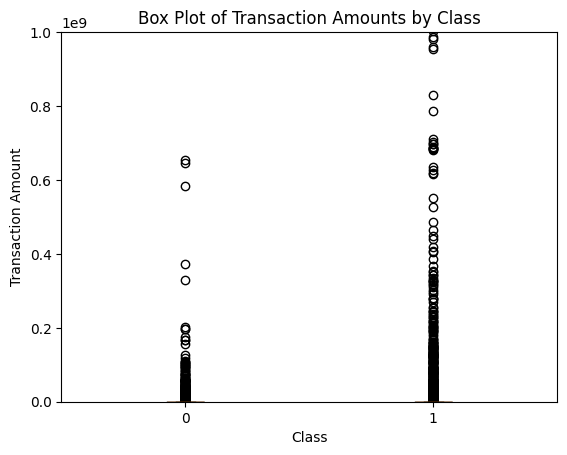

CPU times: total: 2.08 s
Wall time: 3.12 s


In [15]:
%%time

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Find the minimum number of samples among all classes
min_samples = clean_df.groupby('IsLaundering').size().min()
n_samples = {
    0: min_samples * 2,
    1: min_samples,
}

class_0 = clean_df[clean_df['IsLaundering'] == 0].sample(n=n_samples[0])
class_1 = clean_df[clean_df['IsLaundering'] == 1].sample(n=n_samples[1])
                                                         
# Create box plots for each class
plt.boxplot([class_0['AmountReceivedUSD'], class_1['AmountReceivedUSD']], labels=['0', '1'])

# Add labels and title
plt.xlabel('Class')
plt.ylabel('Transaction Amount')
plt.title('Box Plot of Transaction Amounts by Class')

# Set y-axis limit
plt.ylim(0, 1e9)  # Adjust the limits as needed

# Show plot
plt.show()

# GMM for binary classification

Here `min_samples` is the max sample size of the minority class.

```
min_samples = clean_df.groupby('IsLaundering').size().min()
n_samples = {
    0: min_samples * 2,
    1: min_samples,
}
```

We also test with unbalanced data, and find that the accuracy will drop. It tends to predict `1` more.

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE

# Find the minimum number of samples among all classes
min_samples = clean_df.groupby('IsLaundering').size().min()
n_samples = {
    0: min_samples * 10,
    1: min_samples,
}

# Sample an unequal number of samples from each class
class_0 = clean_df[clean_df['IsLaundering'] == 0].sample(n_samples[0], replace=False)  # , random_state=42)
class_1 = clean_df[clean_df['IsLaundering'] == 1].sample(n_samples[1], replace=False)

sampled_df = pd.concat([class_0, class_1])

# sampled_df now contains an equal number of samples from each class
Z = sampled_df[['FromAccount', 'ToAccount', 'FromBank', 'ToBank', 'ReceivingCurrency', 'PaymentCurrency', 'PaymentFormat', 'AmountPaidUSD', 'AmountReceivedUSD']]
scaler = StandardScaler()
X = scaler.set_output(transform='pandas').fit_transform(Z)
y = sampled_df[['IsLaundering']]

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Oversample the minority class using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Fit Gaussian Mixture Model
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
gmm.fit(X_train)

majority_component = np.argmax(gmm.weights_)

# Assign class labels based on mapped GMM components
component_labels = gmm.predict(X_test)

y_pred = np.where(component_labels == majority_component, 0, 1)

print(gmm.weights_)
print(majority_component)

metrics = {
    'accuracy': accuracy_score(y_test, y_pred),
    'f1_score': f1_score(y_test, y_pred, average='weighted'),  # Or use 'macro', 'micro', or None for different averaging methods
    'precision': precision_score(y_test, y_pred),
    'recall': recall_score(y_test, y_pred),
}
print("Metrics:", metrics)

[0.95301923 0.04698077]
0
Metrics: {'accuracy': 0.8675199339405981, 'f1_score': 0.848558641455313, 'precision': 0.04822888283378746, 'recall': 0.02546029919447641}


#### Check the misclassifications

[0.95301923 0.04698077]
Metrics: {'accuracy': 0.8675199339405981, 'f1_score': 0.848558641455313, 'precision': 0.04822888283378746, 'recall': 0.02546029919447641}


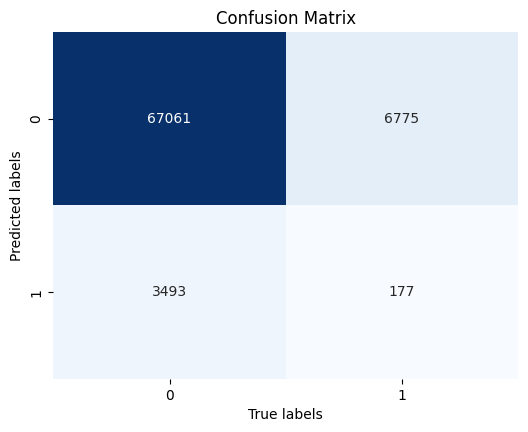

In [40]:
from sklearn.metrics import confusion_matrix

def plot_cm(metrics, y_pred, y_test):
    print("Metrics:", metrics)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_pred, y_test)
    
    # Create a Matplotlib figure
    fig, ax = plt.subplots(figsize=(6, 4.5))
    
    # Plot confusion matrix on the specified axis
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False,
                xticklabels=[0, 1],
                yticklabels=[0, 1], ax=ax)
    for pos in []:
        plt.gca().add_patch(plt.Rectangle(pos, 1, 1, fill=True, color='red', alpha=0.1))  # , edgecolor='red', lw=3))
    plt.xlabel('True labels')
    plt.ylabel('Predicted labels')
    plt.title(f"Confusion Matrix")
    plt.savefig(f"data/cm.png")
    plt.show()
    plt.close()

print(gmm.weights_)
plot_cm(metrics, y_pred, y_test)

In [18]:
# Save processed data for model exploration
# clean_df.to_csv('data/HI_Small_Trans_Standardised.csv', index=False) # Standardised
# output_df.to_csv('data/HI_Small_Trans_Normalised.csv', index=False) # Standardised + Normalisation

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Find the minimum number of samples among all classes
min_samples = clean_df.groupby('IsLaundering').size().min()
n_samples = {
    0: min_samples * 10,
    1: min_samples,
}

# Sample an unequal number of samples from each class
class_0 = clean_df[clean_df['IsLaundering'] == 0].sample(n_samples[0], replace=False)  # , random_state=42)
class_1 = clean_df[clean_df['IsLaundering'] == 1].sample(n_samples[1], replace=False)

sampled_df = pd.concat([class_0, class_1])

# sampled_df now contains an equal number of samples from each class
Z = sampled_df[['FromAccount', 'ToAccount', 'FromBank', 'ToBank', 'ReceivingCurrency', 'PaymentCurrency', 'PaymentFormat', 'AmountPaidUSD', 'AmountReceivedUSD']]
scaler = StandardScaler()
X = scaler.set_output(transform='pandas').fit_transform(Z)
y = sampled_df[['IsLaundering']]

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)  # , random_state=42)

# Fit Gaussian Mixture Model for each class
gmm_class0 = GaussianMixture(n_components=1, covariance_type='full')
gmm_class1 = GaussianMixture(n_components=1, covariance_type='full')

# Filter data for each class
X_train_class0 = X_train[y_train['IsLaundering'] == 0]
X_train_class1 = X_train[y_train['IsLaundering'] == 1]

# Fit GMMs to each class
gmm_class0.fit(X_train_class0)
gmm_class1.fit(X_train_class1)

likelihoods_class0 = gmm_class0.score_samples(X_test)
likelihoods_class1 = gmm_class1.score_samples(X_test)

# Predict class with higher likelihood for each row
y_pred = np.where(likelihoods_class0 > likelihoods_class1, 0, 1)

metrics = {
    'accuracy': accuracy_score(y_test, y_pred),
    'f1_score': f1_score(y_test, y_pred, average='weighted'),  # Or use 'macro', 'micro', or None for different averaging methods
    'precision': precision_score(y_test, y_pred),
    'recall': recall_score(y_test, y_pred),
}
print("Metrics:", metrics)

Metrics: {'accuracy': 0.4668541790313008, 'f1_score': 0.5552711076908052, 'precision': 0.14521267792121814, 'recall': 0.9992881548974943}


[0.1405807 0.8594193]
Metrics: {'accuracy': 0.4668541790313008, 'f1_score': 0.5552711076908052, 'precision': 0.14521267792121814, 'recall': 0.9992881548974943}


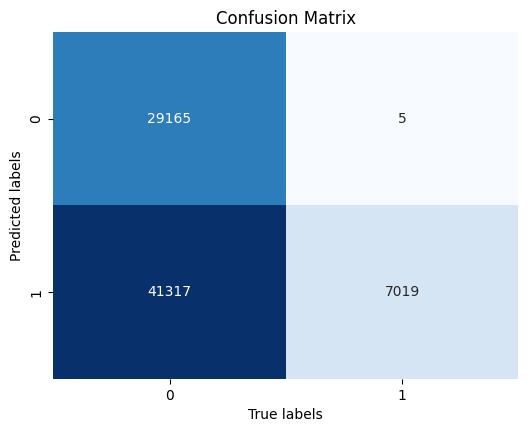

In [38]:
print(gmm.weights_)
plot_cm(metrics, y_pred, y_test)

### GMM sample code on synthetic dataset


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Generate synthetic dataset with adjusted parameters
X, y = make_classification(n_samples=1000, n_features=10, n_classes=2, 
                            n_informative=5, n_redundant=2, n_repeated=1,
                            random_state=42)

# print(X[0:10])

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit Gaussian Mixture Model for each class
gmm_class0 = GaussianMixture(n_components=1, covariance_type='full')
gmm_class1 = GaussianMixture(n_components=1, covariance_type='full')

# Filter data for each class
X_train_class0 = X_train[y_train == 0]
X_train_class1 = X_train[y_train == 1]

# Fit GMMs to each class
gmm_class0.fit(X_train_class0)
gmm_class1.fit(X_train_class1)

# Predict class probabilities for test set
prob_class0 = gmm_class0.score_samples(X_test)
prob_class1 = gmm_class1.score_samples(X_test)

# Assign class labels based on likelihood
y_pred = np.where(prob_class0 > prob_class1, 0, 1)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Plot decision boundary
# Note: Decision boundary plot is not possible in this case due to high-dimensional feature space


Accuracy: 0.875
